# Portfolio vs 10Y Bond: Market Views and Stress-Tests
Joint distribution analysis between portfolio and 10-year zero-coupon bond returns.

**Stress scenarios:**
- Rate spike (bond crash)
- Rate crash (flight to safety)
- Mean/variance views on bond returns
- Correlation stress (2022 regime)

In [2]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data and compute returns

In [4]:
# Load portfolio data
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    'NVDA', 'ISRG', 'APO', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]

existing_assets = [c for c in selected_assets if c in data.columns]
data = data[existing_assets]
data = data[data > 0]
data_clean = data.dropna(axis=0, how='any')

print(f"Portfolio data: {data_clean.shape[0]} days × {data_clean.shape[1]} assets")
print(f"Date range: {data_clean.index[0].date()} → {data_clean.index[-1].date()}")

Portfolio data: 2471 days × 12 assets
Date range: 2016-01-04 → 2025-11-11


In [5]:
# Portfolio weights - 20-fold exposure stacking from optimization
exposures = np.array([
    0.0413,  # NVDA
    0.0516,  # ISRG
    0.0414,  # APO
    0.0597,  # DECK
    0.1624,  # COST
    0.0901,  # CAT
    0.0240,  # BTU
    0.0992,  # SHW
    0.0790,  # NRG
    0.0707,  # NFLX
    0.0519,  # CBRE
    0.2286,  # GC=F
])

# Load 10Y yield and convert to zero-coupon bond returns

In [7]:
# Download 10Y Treasury yield
yield_data = yf.download('^TNX', start=data_clean.index[0], end=data_clean.index[-1])['Close']
yield_data = yield_data.dropna()

# Handle potential MultiIndex from yfinance
if isinstance(yield_data, pd.DataFrame):
    yield_data = yield_data.iloc[:, 0]  # extract first column as Series

yield_data.name = 'US10Y_yield'

print(f"Yield data: {len(yield_data)} days")
print(f"Yield range: {yield_data.min():.2f}% → {yield_data.max():.2f}%")

[*********************100%***********************]  1 of 1 completed

Yield data: 2478 days
Yield range: 0.50% → 4.99%


In [8]:
# Convert yields to zero-coupon bond prices
# P = 100 / (1 + y)^T where T = 10 years (constant maturity)

T = 10  # constant maturity assumption
yields_decimal = yield_data.values / 100  # convert from percentage to decimal
bond_prices = 100 / (1 + yields_decimal) ** T

bond_prices_series = pd.Series(bond_prices, index=yield_data.index, name='ZC10Y_price')

print(f"\nBond price range: ${bond_prices.min():.2f} → ${bond_prices.max():.2f}")
print(f"Current yield: {yields_decimal[-1]*100:.2f}% → Price: ${bond_prices[-1]:.2f}")


Bond price range: $61.46 → $95.14
Current yield: 4.11% → Price: $66.85


In [9]:
# Compute bond log returns
bond_log_returns = np.diff(np.log(bond_prices))
bond_returns_series = pd.Series(
    bond_log_returns, 
    index=yield_data.index[1:], 
    name='ZC10Y'
)

print(f"Bond returns: {len(bond_returns_series)} days")
print(f"Annualized vol: {bond_returns_series.std() * np.sqrt(252) * 100:.1f}%")

Bond returns: 2477 days
Annualized vol: 8.4%


# Align portfolio and bond returns

In [10]:
# Compute portfolio log returns
portfolio_log_returns = np.diff(np.log(data_clean.values), axis=0) @ exposures
portfolio_returns_series = pd.Series(
    portfolio_log_returns,
    index=data_clean.index[1:],
    name='Portfolio'
)

# Align both series
combined = pd.concat([portfolio_returns_series, bond_returns_series], axis=1).dropna()
portfolio_return = combined['Portfolio'].values
bond_return = combined['ZC10Y'].values

print(f"Aligned returns: {len(combined)} days")
print(f"Date range: {combined.index[0].date()} → {combined.index[-1].date()}")

Aligned returns: 2468 days
Date range: 2016-01-05 → 2025-11-10


# Specify prior parameters and simulate

In [11]:
# Annualize for simulation (H = 252 trading days)
H = 252

# Stack portfolio and bond for 2-asset analysis
returns_2d = np.column_stack([portfolio_return, bond_return])
means = np.mean(returns_2d, axis=0) * H
vols = np.std(returns_2d, axis=0) * np.sqrt(H)
corr = np.corrcoef(returns_2d.T)
covariances = np.diag(vols) @ corr @ np.diag(vols)

print(f"Portfolio:  mean={means[0]*100:.1f}%, vol={vols[0]*100:.1f}%")
print(f"10Y Bond:   mean={means[1]*100:.1f}%, vol={vols[1]*100:.1f}%")
print(f"Correlation: {corr[0,1]:.3f}")

Portfolio:  mean=21.0%, vol=17.0%
10Y Bond:   mean=-1.9%, vol=8.4%
Correlation: -0.041


In [12]:
# Simulate log-normal returns
S = 10000
np.random.seed(1337)
log_return = np.random.multivariate_normal(means, covariances, S)
discrete_return = pd.DataFrame(
    np.exp(log_return - np.diag(np.cov(log_return.T)) / 2) - 1,
    columns=['Portfolio', '10Y Bond']
)

In [13]:
# Prior statistics
p = np.ones((S, 1)) / S
prior_stats = ft.simulation_moments(100 * discrete_return, p)
display(np.round(prior_stats, 3))

,Mean,Volatility,Skewness,Kurtosis
Portfolio,23.450,20.951,0.512,3.340
10Y Bond,-1.833,8.148,0.240,3.108


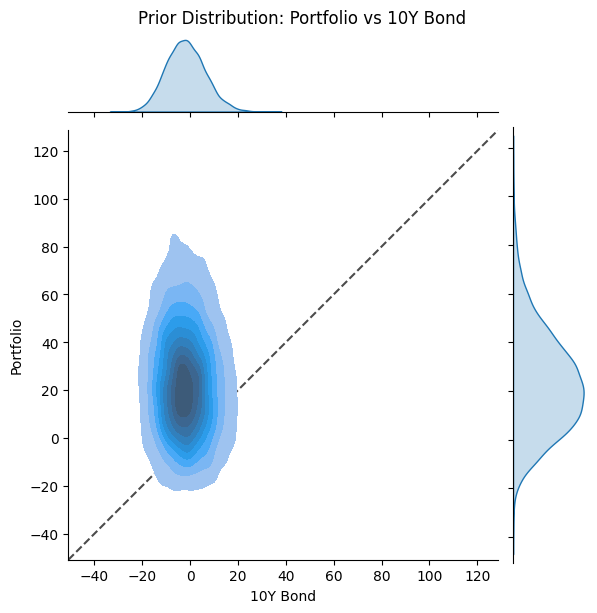

In [18]:
# Prior joint distribution
g = sns.jointplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', kind='kde', fill=True)

lims = [
    min(g.ax_joint.get_xlim()[0], g.ax_joint.get_ylim()[0]),
    max(g.ax_joint.get_xlim()[1], g.ax_joint.get_ylim()[1])
]
g.ax_joint.set_xlim(lims)
g.ax_joint.set_ylim(lims)
g.ax_joint.set_aspect('equal')
g.ax_joint.plot(lims, lims, 'k--', alpha=0.7, zorder=0)


plt.suptitle('Prior Distribution: Portfolio vs 10Y Bond', y=1.02)
plt.show()

---
# View 1: Mean and Variance on 10Y Bond (multipliers)
Specify views on bond expected return and volatility using multipliers relative to prior.

In [21]:
prior_mean_bond = prior_stats['Mean']['10Y Bond'] / 100
prior_vol_bond = prior_stats['Volatility']['10Y Bond'] / 100

print(f"Prior 10Y Bond: mean={prior_mean_bond:.3%}, vol={prior_vol_bond:.3%}")

# === ADJUST THESE MULTIPLIERS ===
mean_mult = 0.5   # e.g., 0.5 = expect bonds to return half of historical
vol_mult = 1.2    # e.g., 1.2 = expect 20% higher volatility

# Or set absolute values directly:
# view_mean = -0.05  # expect -5% bond return (rate spike scenario)
# view_vol = 0.15    # expect 15% volatility

view_mean = mean_mult * prior_mean_bond
view_vol = vol_mult * prior_vol_bond

print(f"View 10Y Bond:  mean={view_mean:.3%}, vol={view_vol:.3%}")

Prior 10Y Bond: mean=-1.833%, vol=8.148%
View 10Y Bond:  mean=-0.917%, vol=9.778%


In [22]:
# Entropy pooling with mean and variance constraints on bond
A_view = np.ones((1, S))
A_view = np.vstack((A_view, discrete_return.values[:, 1]))                    # mean constraint
A_view = np.vstack((A_view, discrete_return.values[:, 1]**2))                 # variance constraint
b_view = np.array([[1., view_mean, view_vol**2 + view_mean**2]]).T

q_view = ft.entropy_pooling(p, A_view, b_view)

relative_entropy_view = q_view.T @ (np.log(q_view) - np.log(p))
effective_scenarios_view = np.exp(-relative_entropy_view)
print(f'Effective scenarios (view): {effective_scenarios_view[0, 0] * 100:.2f}%')
print(f'Relative entropy (view): {relative_entropy_view[0, 0] * 100:.2f}%')

Effective scenarios (view): 96.36%
Relative entropy (view): 3.71%


In [23]:
# Validate view implementation
print("Posterior with mean/vol view:")
display(np.round(ft.simulation_moments(100 * discrete_return, p=q_view), 3))

Posterior with mean/vol view:


,Mean,Volatility,Skewness,Kurtosis
Portfolio,23.383,20.968,0.528,3.385
10Y Bond,-0.917,9.777,0.394,3.234


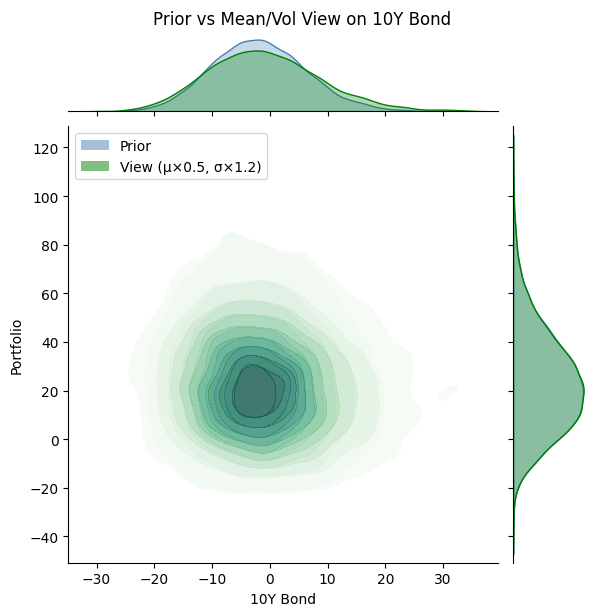

In [24]:
# Joint plot: Prior vs Mean/Vol View
g = sns.JointGrid(data=100 * discrete_return, x='10Y Bond', y='Portfolio')
sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
            fill=True, ax=g.ax_joint, cmap='Blues', alpha=0.5)
sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
            weights=q_view[:, 0], fill=True, ax=g.ax_joint, cmap='Greens', alpha=0.5)

sns.kdeplot(x=100 * discrete_return['10Y Bond'], ax=g.ax_marg_x, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(x=100 * discrete_return['10Y Bond'], weights=q_view[:, 0], ax=g.ax_marg_x, color='green', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], ax=g.ax_marg_y, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], weights=q_view[:, 0], ax=g.ax_marg_y, color='green', fill=True, alpha=0.3)

legend_handles = [Patch(facecolor='steelblue', alpha=0.5, label='Prior'),
                  Patch(facecolor='green', alpha=0.5, label=f'View (μ×{mean_mult}, σ×{vol_mult})')]
g.ax_joint.legend(handles=legend_handles, loc='upper left')
g.figure.suptitle('Prior vs Mean/Vol View on 10Y Bond', y=1.02)
plt.show()

---
# View 2: Absolute Mean and Variance (manual specification)
Directly specify expected bond return and volatility.

In [25]:
# === SET ABSOLUTE VALUES ===
view_mean_abs = -0.08  # expect -8% bond return (significant rate spike)
view_vol_abs = 0.18    # expect 18% volatility

print(f"Prior 10Y Bond: mean={prior_mean_bond:.3%}, vol={prior_vol_bond:.3%}")
print(f"View 10Y Bond:  mean={view_mean_abs:.3%}, vol={view_vol_abs:.3%}")

Prior 10Y Bond: mean=-1.833%, vol=8.148%
View 10Y Bond:  mean=-8.000%, vol=18.000%


In [26]:
A_abs = np.ones((1, S))
A_abs = np.vstack((A_abs, discrete_return.values[:, 1]))
A_abs = np.vstack((A_abs, discrete_return.values[:, 1]**2))
b_abs = np.array([[1., view_mean_abs, view_vol_abs**2 + view_mean_abs**2]]).T

q_abs = ft.entropy_pooling(p, A_abs, b_abs)

relative_entropy_abs = q_abs.T @ (np.log(q_abs) - np.log(p))
effective_scenarios_abs = np.exp(-relative_entropy_abs)
print(f'Effective scenarios (absolute view): {effective_scenarios_abs[0, 0] * 100:.2f}%')
print(f'Relative entropy (absolute view): {relative_entropy_abs[0, 0] * 100:.2f}%')

Effective scenarios (absolute view): 16.71%
Relative entropy (absolute view): 178.94%


In [27]:
print("Posterior with absolute view:")
display(np.round(ft.simulation_moments(100 * discrete_return, p=q_abs), 3))

Posterior with absolute view:


,Mean,Volatility,Skewness,Kurtosis
Portfolio,28.04,26.085,1.045,4.090
10Y Bond,-8.00,18.000,1.045,3.112


---
# Stress Test 1: Rate Spike (Bond at CVaR)
Condition on 10Y bond return being at its 90% CVaR (tail loss).

In [28]:
# Compute bond CVaR
bond_cvar = ft.portfolio_cvar(
    np.array([[0.], [1.]]),  # 100% bond
    discrete_return, 
    alpha=0.9, 
    demean=False
)
print(f'10Y Bond 90%-CVaR = {bond_cvar*100:.2f}%')
print(f'(This represents a severe rate spike scenario)')

10Y Bond 90%-CVaR = 15.39%
(This represents a severe rate spike scenario)


In [29]:
# Condition on bond return = -CVaR
A_spike = np.ones((1, S))
A_spike = np.vstack((A_spike, discrete_return.values[:, 1]))
b_spike = np.array([[1., -bond_cvar]]).T

q_rate_spike = ft.entropy_pooling(p, A_spike, b_spike)

relative_entropy_spike = q_rate_spike.T @ (np.log(q_rate_spike) - np.log(p))
effective_scenarios_spike = np.exp(-relative_entropy_spike)
print(f'Effective scenarios (rate spike): {effective_scenarios_spike[0, 0] * 100:.2f}%')
print(f'Relative entropy (rate spike): {relative_entropy_spike[0, 0] * 100:.2f}%')

Effective scenarios (rate spike): 20.17%
Relative entropy (rate spike): 160.10%


In [30]:
print(f"\nWhen 10Y Bond is at its CVaR ({-bond_cvar*100:.1f}%):")
stats_spike = ft.simulation_moments(100 * discrete_return, q_rate_spike)
display(np.round(stats_spike, 3))


When 10Y Bond is at its CVaR (-15.4%):


,Mean,Volatility,Skewness,Kurtosis
Portfolio,26.029,23.285,0.785,4.051
10Y Bond,-15.387,6.486,0.252,3.095


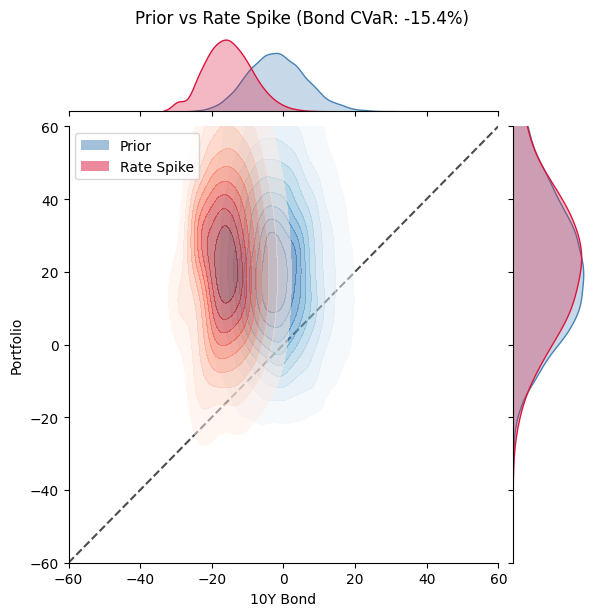

In [31]:
# Joint plot: Prior vs Rate Spike
g = sns.JointGrid(data=100 * discrete_return, x='10Y Bond', y='Portfolio')
sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
            fill=True, ax=g.ax_joint, cmap='Blues', alpha=0.5)
sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
            weights=q_rate_spike[:, 0], fill=True, ax=g.ax_joint, cmap='Reds', alpha=0.5)

sns.kdeplot(x=100 * discrete_return['10Y Bond'], ax=g.ax_marg_x, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(x=100 * discrete_return['10Y Bond'], weights=q_rate_spike[:, 0], ax=g.ax_marg_x, color='crimson', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], ax=g.ax_marg_y, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], weights=q_rate_spike[:, 0], ax=g.ax_marg_y, color='crimson', fill=True, alpha=0.3)

g.ax_joint.set_xlim(-60, 60)
g.ax_joint.set_ylim(-60, 60)

legend_handles = [Patch(facecolor='steelblue', alpha=0.5, label='Prior'),
                  Patch(facecolor='crimson', alpha=0.5, label='Rate Spike')]
g.ax_joint.legend(handles=legend_handles, loc='upper left')
g.figure.suptitle(f'Prior vs Rate Spike (Bond CVaR: {-bond_cvar*100:.1f}%)', y=1.02)
g.ax_joint.plot([-60, 60], [-60, 60], 'k--', alpha=0.7, zorder=0)
plt.show()

---
# Stress Test 2: Flight to Safety (Bond Rally)
Condition on bond returns being very positive (rate crash / flight to quality).

In [32]:
# For flight to safety, condition on bond return at positive tail
# Use negative of CVaR on inverted returns (or just positive CVaR magnitude)
bond_rally = bond_cvar  # same magnitude but positive
print(f'Flight to safety scenario: Bond return = +{bond_rally*100:.2f}%')

Flight to safety scenario: Bond return = +15.39%


In [33]:
A_fts = np.ones((1, S))
A_fts = np.vstack((A_fts, discrete_return.values[:, 1]))
b_fts = np.array([[1., bond_rally]]).T  # positive bond return

q_flight_to_safety = ft.entropy_pooling(p, A_fts, b_fts)

relative_entropy_fts = q_flight_to_safety.T @ (np.log(q_flight_to_safety) - np.log(p))
effective_scenarios_fts = np.exp(-relative_entropy_fts)
print(f'Effective scenarios (flight to safety): {effective_scenarios_fts[0, 0] * 100:.2f}%')
print(f'Relative entropy (flight to safety): {relative_entropy_fts[0, 0] * 100:.2f}%')

Effective scenarios (flight to safety): 14.82%
Relative entropy (flight to safety): 190.89%


In [34]:
print(f"\nWhen 10Y Bond rallies (+{bond_rally*100:.1f}%):")
stats_fts = ft.simulation_moments(100 * discrete_return, q_flight_to_safety)
display(np.round(stats_fts, 3))


When 10Y Bond rallies (+15.4%):


,Mean,Volatility,Skewness,Kurtosis
Portfolio,22.334,20.181,0.572,3.384
10Y Bond,15.387,9.849,-0.028,2.462


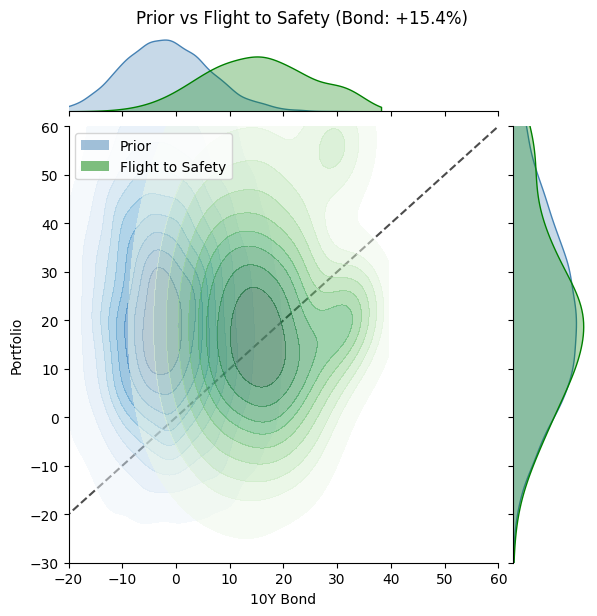

In [36]:
# Joint plot: Prior vs Flight to Safety
g = sns.JointGrid(data=100 * discrete_return, x='10Y Bond', y='Portfolio')
sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
            fill=True, ax=g.ax_joint, cmap='Blues', alpha=0.5)
sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
            weights=q_flight_to_safety[:, 0], fill=True, ax=g.ax_joint, cmap='Greens', alpha=0.5)

sns.kdeplot(x=100 * discrete_return['10Y Bond'], ax=g.ax_marg_x, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(x=100 * discrete_return['10Y Bond'], weights=q_flight_to_safety[:, 0], ax=g.ax_marg_x, color='green', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], ax=g.ax_marg_y, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], weights=q_flight_to_safety[:, 0], ax=g.ax_marg_y, color='green', fill=True, alpha=0.3)

g.ax_joint.set_xlim(-20, 60)
g.ax_joint.set_ylim(-30, 60)

legend_handles = [Patch(facecolor='steelblue', alpha=0.5, label='Prior'),
                  Patch(facecolor='green', alpha=0.5, label='Flight to Safety')]
g.ax_joint.legend(handles=legend_handles, loc='upper left')
g.figure.suptitle(f'Prior vs Flight to Safety (Bond: +{bond_rally*100:.1f}%)', y=1.02)
g.ax_joint.plot([-60, 60], [-60, 60], 'k--', alpha=0.7, zorder=0)
plt.show()

---
# Stress Test 3: 2022 Regime (Correlation Breakdown)
Both stocks and bonds down together - positive correlation stress.

In [37]:
# First condition on portfolio at CVaR
portfolio_cvar = ft.portfolio_cvar(
    np.array([[1.], [0.]]),  # 100% portfolio
    discrete_return, 
    alpha=0.9, 
    demean=False
)
print(f'Portfolio 90%-CVaR = {portfolio_cvar*100:.2f}%')

# Intermediate stress: portfolio at CVaR
A0 = np.ones((1, S))
A0 = np.vstack((A0, discrete_return.values[:, 0]))
b0 = np.array([[1., -portfolio_cvar]]).T
q0 = ft.entropy_pooling(p, A0, b0)

stats0 = ft.simulation_moments(discrete_return, q0)
print(f"\nIntermediate stress statistics:")
display(np.round(stats0, 3))

Portfolio 90%-CVaR = 8.98%

Intermediate stress statistics:


,Mean,Volatility,Skewness,Kurtosis
Portfolio,-0.090,0.135,0.266,3.322
10Y Bond,-0.012,0.083,0.150,2.904


In [38]:
# 2022 regime: spike correlation to positive (both assets move together)
stress_correlation = 0.50  # positive correlation (diversification fails)

A_2022 = np.ones((1, S))
# Means
A_2022 = np.vstack((A_2022, discrete_return.values[:, 0:2].T))
# Volatilities
A_2022 = np.vstack((A_2022, (discrete_return.values[:, 0:2].T - stats0['Mean'].values[0:2][:, np.newaxis])**2))
# Correlation
A_2022 = np.vstack((A_2022, 
    (discrete_return.values[:, 0] - stats0['Mean'].values[0]) * 
    (discrete_return.values[:, 1] - stats0['Mean'].values[1]) /
    (stats0['Volatility'].values[0] * stats0['Volatility'].values[1])
))

b_2022 = np.array([[1., *stats0['Mean'].iloc[0:2], *stats0['Volatility'].iloc[0:2]**2, stress_correlation]]).T

In [39]:
q_2022 = ft.entropy_pooling(p, A_2022, b_2022)

relative_entropy_2022 = q_2022.T @ (np.log(q_2022) - np.log(p))
effective_scenarios_2022 = np.exp(-relative_entropy_2022)
print(f'Effective scenarios (2022 regime): {effective_scenarios_2022[0, 0] * 100:.2f}%')
print(f'Relative entropy (2022 regime): {relative_entropy_2022[0, 0] * 100:.2f}%')

Effective scenarios (2022 regime): 16.49%
Relative entropy (2022 regime): 180.25%


In [40]:
print(f"\n2022 Regime (correlation = {stress_correlation}):")
stats_2022 = ft.simulation_moments(100 * discrete_return, q_2022)
display(np.round(stats_2022, 3))

print(f"\nPosterior correlation:")
display(ft.correlation_matrix(discrete_return, q_2022))


2022 Regime (correlation = 0.5):


,Mean,Volatility,Skewness,Kurtosis
Portfolio,-8.982,13.496,0.388,3.559
10Y Bond,-1.180,8.292,0.262,3.276



Posterior correlation:


,0,1
"(0, Portfolio)",1.0,0.5
"(1, 10Y Bond)",0.5,1.0


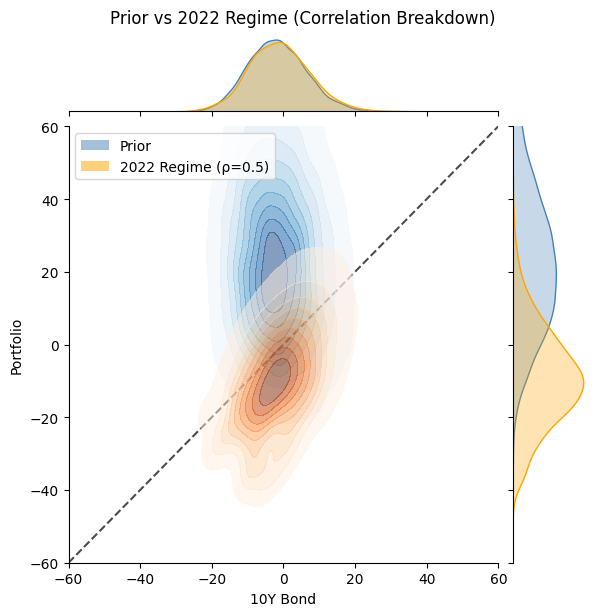

In [41]:
# Joint plot: Prior vs 2022 Regime
g = sns.JointGrid(data=100 * discrete_return, x='10Y Bond', y='Portfolio')
sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
            fill=True, ax=g.ax_joint, cmap='Blues', alpha=0.5)
sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
            weights=q_2022[:, 0], fill=True, ax=g.ax_joint, cmap='Oranges', alpha=0.5)

sns.kdeplot(x=100 * discrete_return['10Y Bond'], ax=g.ax_marg_x, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(x=100 * discrete_return['10Y Bond'], weights=q_2022[:, 0], ax=g.ax_marg_x, color='orange', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], ax=g.ax_marg_y, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], weights=q_2022[:, 0], ax=g.ax_marg_y, color='orange', fill=True, alpha=0.3)

g.ax_joint.set_xlim(-60, 60)
g.ax_joint.set_ylim(-60, 60)

legend_handles = [Patch(facecolor='steelblue', alpha=0.5, label='Prior'),
                  Patch(facecolor='orange', alpha=0.5, label=f'2022 Regime (ρ={stress_correlation})')]
g.ax_joint.legend(handles=legend_handles, loc='upper left')
g.figure.suptitle('Prior vs 2022 Regime (Correlation Breakdown)', y=1.02)
g.ax_joint.plot([-60, 60], [-60, 60], 'k--', alpha=0.7, zorder=0)
plt.show()

---
# Summary Comparison

In [42]:
# Summary table
prior_stats_raw = ft.simulation_moments(discrete_return, p)

summary = pd.DataFrame({
    'Prior': [
        prior_stats_raw['Mean']['Portfolio'] * 100,
        prior_stats_raw['Mean']['10Y Bond'] * 100,
        prior_stats_raw['Volatility']['Portfolio'] * 100,
        prior_stats_raw['Volatility']['10Y Bond'] * 100,
        ft.correlation_matrix(discrete_return, p).iloc[0, 1],
        100.0
    ],
    'Mean/Vol View': [
        ft.simulation_moments(discrete_return, q_view)['Mean']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, q_view)['Mean']['10Y Bond'] * 100,
        ft.simulation_moments(discrete_return, q_view)['Volatility']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, q_view)['Volatility']['10Y Bond'] * 100,
        ft.correlation_matrix(discrete_return, q_view).iloc[0, 1],
        effective_scenarios_view[0, 0] * 100
    ],
    'Rate Spike': [
        ft.simulation_moments(discrete_return, q_rate_spike)['Mean']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, q_rate_spike)['Mean']['10Y Bond'] * 100,
        ft.simulation_moments(discrete_return, q_rate_spike)['Volatility']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, q_rate_spike)['Volatility']['10Y Bond'] * 100,
        ft.correlation_matrix(discrete_return, q_rate_spike).iloc[0, 1],
        effective_scenarios_spike[0, 0] * 100
    ],
    'Flight to Safety': [
        ft.simulation_moments(discrete_return, q_flight_to_safety)['Mean']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, q_flight_to_safety)['Mean']['10Y Bond'] * 100,
        ft.simulation_moments(discrete_return, q_flight_to_safety)['Volatility']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, q_flight_to_safety)['Volatility']['10Y Bond'] * 100,
        ft.correlation_matrix(discrete_return, q_flight_to_safety).iloc[0, 1],
        effective_scenarios_fts[0, 0] * 100
    ],
    '2022 Regime': [
        ft.simulation_moments(discrete_return, q_2022)['Mean']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, q_2022)['Mean']['10Y Bond'] * 100,
        ft.simulation_moments(discrete_return, q_2022)['Volatility']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, q_2022)['Volatility']['10Y Bond'] * 100,
        ft.correlation_matrix(discrete_return, q_2022).iloc[0, 1],
        effective_scenarios_2022[0, 0] * 100
    ]
}, index=['Portfolio Mean (%)', '10Y Bond Mean (%)', 'Portfolio Vol (%)', '10Y Bond Vol (%)', 
          'Correlation', 'Effective Scenarios (%)'])

np.round(summary, 2)

,Prior,Mean/Vol View,Rate Spike,Flight to Safety,2022 Regime
Portfolio Mean (%),23.45,23.38,26.03,22.33,-8.98
10Y Bond Mean (%),-1.83,-0.92,-15.39,15.39,-1.18
Portfolio Vol (%),20.95,20.97,23.28,20.18,13.50
10Y Bond Vol (%),8.15,9.78,6.49,9.85,8.29
Correlation,-0.06,-0.06,-0.11,0.04,0.50
Effective Scenarios (%),100.00,96.36,20.17,14.82,16.49


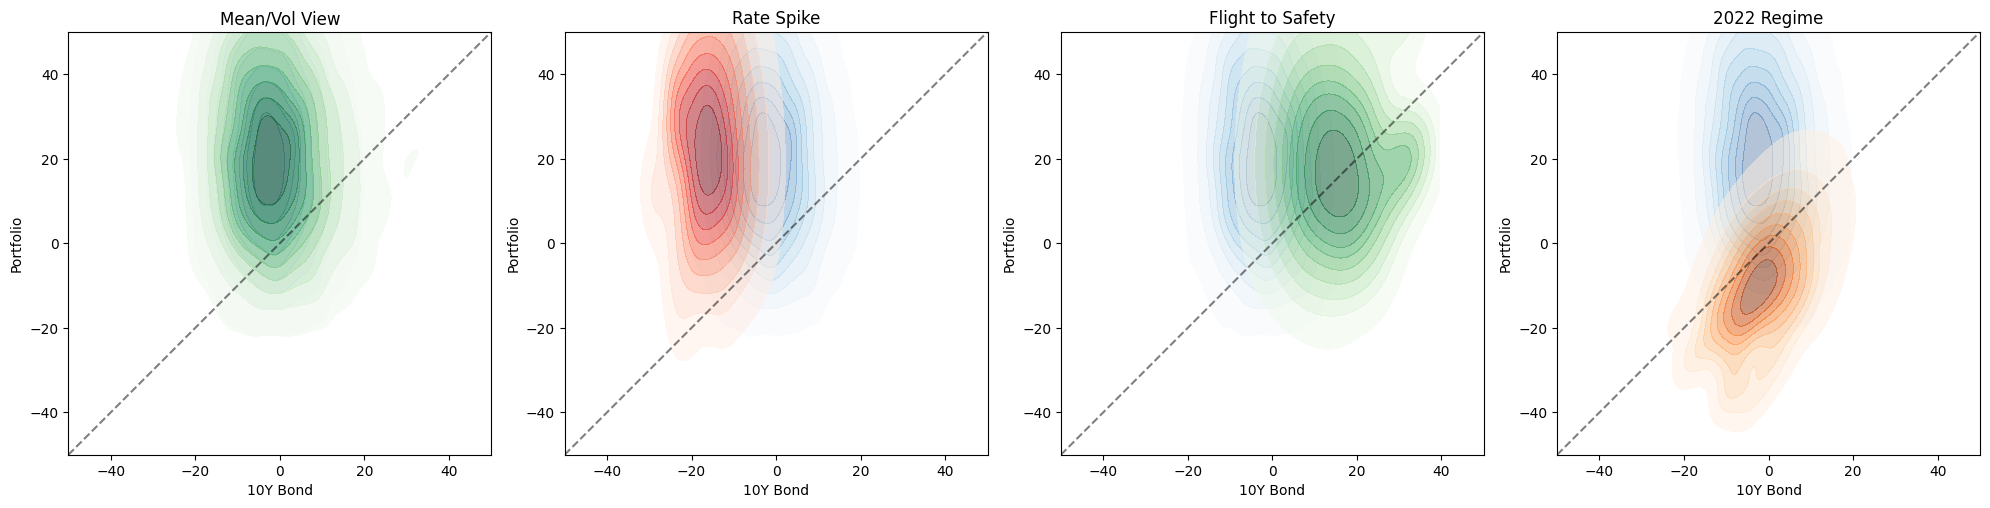

In [43]:
# All scenarios comparison plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

scenarios = [
    ('Mean/Vol View', q_view, 'Greens'),
    ('Rate Spike', q_rate_spike, 'Reds'),
    ('Flight to Safety', q_flight_to_safety, 'Greens'),
    ('2022 Regime', q_2022, 'Oranges')
]

for ax, (title, q, cmap) in zip(axes, scenarios):
    sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
                fill=True, ax=ax, cmap='Blues', alpha=0.3)
    sns.kdeplot(data=100 * discrete_return, x='10Y Bond', y='Portfolio', 
                weights=q[:, 0], fill=True, ax=ax, cmap=cmap, alpha=0.5)
    ax.set_title(title)
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.plot([-50, 50], [-50, 50], 'k--', alpha=0.5)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

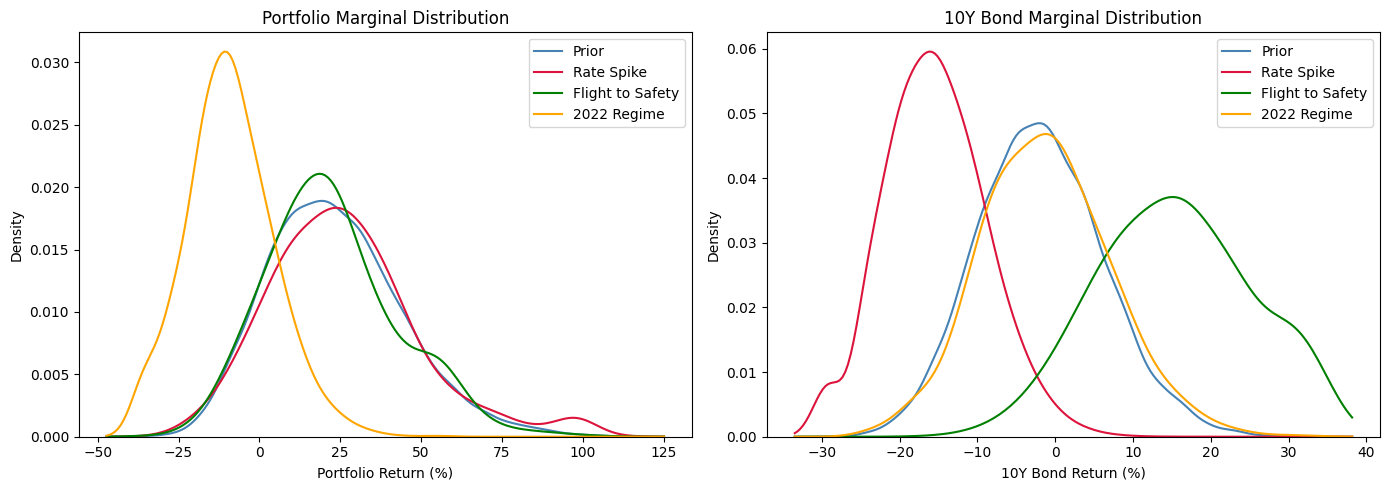

In [44]:
# Marginal distributions comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Portfolio marginal
ax1 = axes[0]
sns.kdeplot(x=100 * discrete_return['Portfolio'], ax=ax1, label='Prior', color='steelblue')
sns.kdeplot(x=100 * discrete_return['Portfolio'], weights=q_rate_spike[:, 0], ax=ax1, label='Rate Spike', color='crimson')
sns.kdeplot(x=100 * discrete_return['Portfolio'], weights=q_flight_to_safety[:, 0], ax=ax1, label='Flight to Safety', color='green')
sns.kdeplot(x=100 * discrete_return['Portfolio'], weights=q_2022[:, 0], ax=ax1, label='2022 Regime', color='orange')
ax1.set_xlabel('Portfolio Return (%)')
ax1.set_title('Portfolio Marginal Distribution')
ax1.legend()

# Bond marginal
ax2 = axes[1]
sns.kdeplot(x=100 * discrete_return['10Y Bond'], ax=ax2, label='Prior', color='steelblue')
sns.kdeplot(x=100 * discrete_return['10Y Bond'], weights=q_rate_spike[:, 0], ax=ax2, label='Rate Spike', color='crimson')
sns.kdeplot(x=100 * discrete_return['10Y Bond'], weights=q_flight_to_safety[:, 0], ax=ax2, label='Flight to Safety', color='green')
sns.kdeplot(x=100 * discrete_return['10Y Bond'], weights=q_2022[:, 0], ax=ax2, label='2022 Regime', color='orange')
ax2.set_xlabel('10Y Bond Return (%)')
ax2.set_title('10Y Bond Marginal Distribution')
ax2.legend()

plt.tight_layout()
plt.show()